In [1]:
#importing processed data
import pandas as pd
df = pd.read_csv('all_data.csv', index_col = 0)

/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#dropping all features with NAN
df = df.dropna(axis=1,how='any')

In [3]:
#Checking whether application is in both 
df_check = None
frames = []
df_v = []
df_p = []
for name, item in df.groupby(['kernelname', 'input']):
    df_1 = df[ df['kernelname'] == name[0] ]
    df_2 = df_1[ df_1['input'] == name[1] ]
    if len(df_2) == 2:
        
        df_v = df_2[df_2['architecture'] == 'V100']
        df_p = df_2[df_2['architecture'] == 'P100']
        df_p['ipc'][0] = df_v.iloc[0]['ipc']
        frames.append(df_p)
     
new_df = pd.concat(frames)

#print(new_df)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#Splitting data with respect to architure
df_P100 = df[ df['architecture'] == 'P100' ]
df_V100 = df[ df['architecture'] == 'V100' ]


In [5]:
#Normalize Data 
#Columns with text: architecture, kernel, input, 
#application_name, kernalname
# new_def has p100 app metrics with v100 ipc
# Normalize df_p100

In [177]:
#Dropping all columns with strings
df_p100_norm = df_P100.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','kernel','input','application_name','kernelname','ipc'])





In [178]:
new_def_norm = new_df.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','kernel','input','ipc','application_name','kernelname'])




## V100 DATA Split

In [179]:
#V100 Data
df_v100_ipc = df_V100['ipc']
df_v100_ipc_values = df_v100_ipc.values

df_v100_noipc = df_V100.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','kernel','input','application_name','kernelname','ipc'])
df_v100_noipc_values = df_v100_noipc.values
df_v100_noipc_norm = MinMaxScaler().fit_transform(df_v100_noipc_values)

# Split the data up in train and test sets
XV_train, XV_test, yV_train, yV_test = train_test_split(df_v100_noipc_norm, df_v100_ipc_values, test_size=0.33, random_state=42)


In [180]:
print('P100 data shape', df_p100_norm.shape)
print('V100 ipc with p100 metrics', new_def_norm.shape)

P100 data shape (13866, 113)
V100 ipc with p100 metrics (2584, 113)


## Normalized data for mixed data metrics

In [181]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#ipc values
new_def_ipc = new_df['ipc']
new_def_ipc_values = new_def_ipc.values
#new_def_ipc_norm = MinMaxScaler().fit_transform(new_def_ipc_values)

#v100+p100 combined
new_def_norm_values = new_def_norm.values
new_def_norm = MinMaxScaler().fit_transform(new_def_norm_values)

#p100 only normalized
df_p100_ipc = df_P100.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','kernel','input','application_name','kernelname'])
df_p100_ipc = df_p100_ipc['ipc']
p100_ipc_values = df_p100_ipc.values
#p100_ipc_norm = MinMaxScaler().fit_transform(p100_ipc_values)

#no ipc
df_p100_norm = df_P100.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','kernel','input','application_name','kernelname','ipc'])
df_p100_norm = df_p100_norm.values
df_p100_norm = MinMaxScaler().fit_transform(df_p100_norm)


## Splitting data to train and test sets: P100 Data

In [182]:
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split
X_P = df_p100_norm
Y_P = p100_ipc_values

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_P, Y_P, test_size=0.33, random_state=42)



## Splitting data to train and test sets: P100 data with IPC

In [183]:
X_VP = new_def_norm 
Y_VP = new_def_ipc_values

# Split the data up in train and test sets
X_trainVP, X_testVP, y_trainVP, y_testVP = train_test_split(X_VP, Y_VP, test_size=0.33, random_state=42)

## Standardize the Data: P100

In [184]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler1 = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler1.transform(X_train)

# Scale the test set
X_test = scaler1.transform(X_test)

## Standardize the Data: V100

In [185]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(XV_train)

# Scale the train set
XV_train = scaler.transform(XV_train)

# Scale the test set
XV_test = scaler.transform(XV_test)

## Standardize the Data: P100 data with V100 IPC

In [186]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
#scalerVP = StandardScaler().fit(X_trainVP)
scalerVP = StandardScaler().fit(X_trainVP)

# Scale the train set
X_trainVP = scaler1.transform(X_trainVP)

# Scale the test set
X_testVP = scaler1.transform(X_testVP)



## Transfer Learning Model

In [187]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
# load pima indians dataset
#dataset = pd.read_csv("p100_only.csv", delimiter=",").values
# split into input (X) and output (Y) variables
#X = dataset[:,0:8]
#Y = dataset[:,8]
# create model
def my_model():
    model = Sequential()
    model.add(Dense(12, input_dim=113, kernel_initializer='normal',activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='relu'))
    # Compile model
    #mean absolute percentage error - indicating that we seek to minimize the mean percentage difference between 
    #predicted ipc and the actual ipc
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    # Fit the model
    ## model.fit(X, Y, epochs=10, batch_size=10) ##works

    """
    # evaluate the model
    scores = model.evaluate(X, Y)
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))"""
    return model

In [188]:
print(X_P.shape)
print(Y_P.shape)

(13866, 113)
(13866,)


In [189]:
model = my_model()
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1,validation_split=0.2)

Train on 7432 samples, validate on 1858 samples
Epoch 1/100
7432/7432 [==============================] - 1s 96us/step - loss: 0.4499 - mean_squared_error: 0.4499 - mean_absolute_error: 0.3875 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0333
Epoch 2/100
7432/7432 [==============================] - 0s 27us/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0308 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0260
Epoch 3/100
7432/7432 [==============================] - 0s 26us/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0240 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0228
Epoch 4/100
7432/7432 [==============================] - 0s 26us/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0215 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0211
Epoch 5/100
7432/7432 [=========

Epoch 36/100
7432/7432 [==============================] - 0s 27us/step - loss: 8.7120e-04 - mean_squared_error: 8.7120e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0126
Epoch 37/100
7432/7432 [==============================] - 0s 29us/step - loss: 9.9450e-04 - mean_squared_error: 9.9450e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0153
Epoch 38/100
7432/7432 [==============================] - 0s 27us/step - loss: 8.9904e-04 - mean_squared_error: 8.9904e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0135
Epoch 39/100
7432/7432 [==============================] - 0s 28us/step - loss: 8.3963e-04 - mean_squared_error: 8.3963e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0126
Epoch 40/100
7432/7432 [====================

7432/7432 [==============================] - 0s 27us/step - loss: 8.3285e-04 - mean_squared_error: 8.3285e-04 - mean_absolute_error: 0.0132 - val_loss: 9.9836e-04 - val_mean_squared_error: 9.9836e-04 - val_mean_absolute_error: 0.0151
Epoch 70/100
7432/7432 [==============================] - 0s 26us/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0173 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0136
Epoch 71/100
7432/7432 [==============================] - 0s 26us/step - loss: 9.4448e-04 - mean_squared_error: 9.4448e-04 - mean_absolute_error: 0.0127 - val_loss: 8.8511e-04 - val_mean_squared_error: 8.8511e-04 - val_mean_absolute_error: 0.0148
Epoch 72/100
7432/7432 [==============================] - 0s 24us/step - loss: 5.8004e-04 - mean_squared_error: 5.8004e-04 - mean_absolute_error: 0.0120 - val_loss: 8.4254e-04 - val_mean_squared_error: 8.4254e-04 - val_mean_absolute_error: 0.0121
Epoch 73/100
7432/7432 [=================

## Predict Values

In [190]:
y_pred = model.predict(X_test)

In [191]:
y_pred[:10]

array([[0.66208327],
       [0.83540976],
       [0.67873657],
       [1.8914859 ],
       [0.72028327],
       [1.8945086 ],
       [1.7378682 ],
       [0.68053234],
       [1.8869028 ],
       [1.8942962 ]], dtype=float32)

In [192]:
y_test[:10]

array([0.65449 , 0.845488, 0.674394, 1.877715, 0.720841, 1.883566,
       1.726499, 0.684146, 1.877037, 1.88372 ])

R: 0.998583460930064
MAE: 0.014726310180700426 s
RMSE: 0.03427905136284495 s


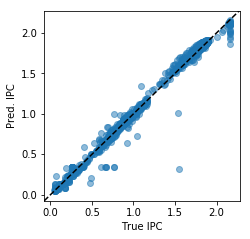

In [193]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Plotting predicted vs true
print ("R:",  sp.stats.pearsonr(y_test, y_pred.flatten())[0])
print ("MAE:", np.abs(y_pred.flatten() - y_test).mean(), 's')
print ("RMSE:", np.sqrt(np.power(y_test- y_pred.flatten(), 2).mean()), 's')


fig, ax = plt.subplots()

# Make the plot
ax.scatter(y_test, y_pred, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True IPC')
ax.set_ylabel('Pred. IPC')

fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');

## Evaluate Model

In [194]:
score = model.evaluate(X_test, y_test,verbose=1)
print(score)

4576/4576 [==============================] - 0s 15us/step
[0.0011750533105276356, 0.0011750533105276356, 0.014726309998000002]


In [195]:
preds = y_pred

In [196]:
import numpy as np

diff = preds.flatten() - y_test
percentDiff = (diff/y_test)*100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("Computing final mean absolute percentage error where it tells you how 'off' it is \n")
print("[INFO] avg. ipc: {}, std ipc: {}".format(new_df['ipc'].mean(),new_df['ipc'].std()))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))


Computing final mean absolute percentage error where it tells you how 'off' it is 

[INFO] avg. ipc: 0.67498251625387, std ipc: 0.3364914396324231
[INFO] mean: 1.84%, std: 6.89%


In [197]:
train_error =  np.abs(preds.flatten() - y_test)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

In [198]:
history = model.fit(X_train, y_train, epochs=100, batch_size=50,  verbose=1, validation_split=0.2)


Train on 7432 samples, validate on 1858 samples
Epoch 1/100
7432/7432 [==============================] - 0s 33us/step - loss: 4.4521e-04 - mean_squared_error: 4.4521e-04 - mean_absolute_error: 0.0102 - val_loss: 6.6082e-04 - val_mean_squared_error: 6.6082e-04 - val_mean_absolute_error: 0.0104
Epoch 2/100
7432/7432 [==============================] - 0s 28us/step - loss: 8.3170e-04 - mean_squared_error: 8.3170e-04 - mean_absolute_error: 0.0130 - val_loss: 7.1891e-04 - val_mean_squared_error: 7.1891e-04 - val_mean_absolute_error: 0.0104
Epoch 3/100
7432/7432 [==============================] - 0s 26us/step - loss: 8.0929e-04 - mean_squared_error: 8.0929e-04 - mean_absolute_error: 0.0123 - val_loss: 8.4853e-04 - val_mean_squared_error: 8.4853e-04 - val_mean_absolute_error: 0.0112
Epoch 4/100
7432/7432 [==============================] - 0s 26us/step - loss: 4.7108e-04 - mean_squared_error: 4.7108e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean

7432/7432 [==============================] - 0s 27us/step - loss: 4.4509e-04 - mean_squared_error: 4.4509e-04 - mean_absolute_error: 0.0111 - val_loss: 6.2306e-04 - val_mean_squared_error: 6.2306e-04 - val_mean_absolute_error: 0.0089
Epoch 35/100
7432/7432 [==============================] - 0s 29us/step - loss: 7.8055e-04 - mean_squared_error: 7.8055e-04 - mean_absolute_error: 0.0118 - val_loss: 6.4817e-04 - val_mean_squared_error: 6.4817e-04 - val_mean_absolute_error: 0.0089
Epoch 36/100
7432/7432 [==============================] - 0s 25us/step - loss: 3.9291e-04 - mean_squared_error: 3.9291e-04 - mean_absolute_error: 0.0096 - val_loss: 6.4764e-04 - val_mean_squared_error: 6.4764e-04 - val_mean_absolute_error: 0.0100
Epoch 37/100
7432/7432 [==============================] - 0s 25us/step - loss: 3.0361e-04 - mean_squared_error: 3.0361e-04 - mean_absolute_error: 0.0088 - val_loss: 7.1116e-04 - val_mean_squared_error: 7.1116e-04 - val_mean_absolute_error: 0.0112
Epoch 38/100
7432/7432 [=

7432/7432 [==============================] - 0s 27us/step - loss: 3.1200e-04 - mean_squared_error: 3.1200e-04 - mean_absolute_error: 0.0087 - val_loss: 6.5929e-04 - val_mean_squared_error: 6.5929e-04 - val_mean_absolute_error: 0.0096
Epoch 68/100
7432/7432 [==============================] - 0s 26us/step - loss: 3.3788e-04 - mean_squared_error: 3.3788e-04 - mean_absolute_error: 0.0093 - val_loss: 6.8345e-04 - val_mean_squared_error: 6.8345e-04 - val_mean_absolute_error: 0.0118
Epoch 69/100
7432/7432 [==============================] - 0s 25us/step - loss: 3.7754e-04 - mean_squared_error: 3.7754e-04 - mean_absolute_error: 0.0102 - val_loss: 6.6306e-04 - val_mean_squared_error: 6.6306e-04 - val_mean_absolute_error: 0.0098
Epoch 70/100
7432/7432 [==============================] - 0s 26us/step - loss: 3.5666e-04 - mean_squared_error: 3.5666e-04 - mean_absolute_error: 0.0094 - val_loss: 6.7977e-04 - val_mean_squared_error: 6.7977e-04 - val_mean_absolute_error: 0.0094
Epoch 71/100
7432/7432 [=

7432/7432 [==============================] - 0s 27us/step - loss: 5.8844e-04 - mean_squared_error: 5.8844e-04 - mean_absolute_error: 0.0102 - val_loss: 6.2436e-04 - val_mean_squared_error: 6.2436e-04 - val_mean_absolute_error: 0.0087


dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


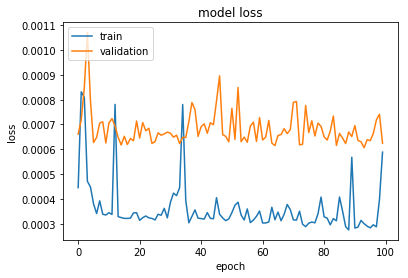

In [199]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Showing difference between V100 and P100 predictions - 
The prediction of V100 ipc using only p100 data

Showing how different are the architectures

R: 0.5699828222309624
MAE: 0.8772685373164127
RMSE: 1.199688489319102


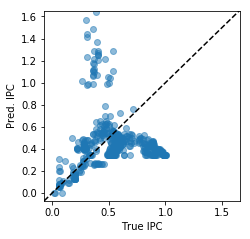

In [200]:
predict_v = model.predict(X_testVP)
import scipy as sp
# Plotting predicted vs true
print ("R:",  sp.stats.pearsonr(y_testVP, predict_v.flatten())[0])
print ("MAE:", np.abs(predict_v.flatten() - y_testVP).mean())
print ("RMSE:", np.sqrt(np.power(y_testVP - predict_v.flatten(), 2).mean()))


fig, ax = plt.subplots()

# Make the plot
ax.scatter(y_testVP, predict_v, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True IPC')
ax.set_ylabel('Pred. IPC')

fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');

## Predicting V100 IPC without transfer learning
Trying to predict V100 IPC given V100 metrics, however model is trained to predict P100 ipc given p100 metrics

Using: XV_train, XV_test, yV_train, yV_test

In [201]:
predict_v = model.predict(XV_test)

R: 0.7574797444601934
MAE: 0.2695077340399303
RMSE: 0.3880798695632757


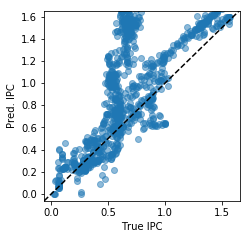

In [202]:
import scipy as sp
# Plotting predicted vs true
print ("R:",  sp.stats.pearsonr(yV_test, predict_v.flatten())[0])
print ("MAE:", np.abs(predict_v.flatten() - yV_test).mean())
print ("RMSE:", np.sqrt(np.power(yV_test- predict_v.flatten(), 2).mean()))


fig, ax = plt.subplots()

# Make the plot
ax.scatter(yV_test, predict_v, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True IPC')
ax.set_ylabel('Pred. IPC')

fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');

## Fining and Transfer learning with V100 IPC

In [203]:
model.save_weights('p100_lim_trained.h5')

In [204]:
from keras.models import load_model

new_model = model
for layer in new_model.layers[:3]:
    layer.trainable=False
for layer in new_model.layers[3:]:
    layer.trainable=True

new_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])


In [205]:
print(X_trainVP.shape)
print(y_trainVP.shape)

(1731, 113)
(1731,)


In [206]:
X = X_trainVP
Y = y_trainVP
new_model.fit(X, Y, epochs=150, batch_size=10,  validation_split= 0.25, shuffle=True)

Train on 1298 samples, validate on 433 samples
Epoch 1/150
1298/1298 [==============================] - 1s 436us/step - loss: 0.3711 - mean_squared_error: 0.3711 - mean_absolute_error: 0.4389 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - val_mean_absolute_error: 0.2843
Epoch 2/150
1298/1298 [==============================] - 0s 131us/step - loss: 0.1162 - mean_squared_error: 0.1162 - mean_absolute_error: 0.2810 - val_loss: 0.1083 - val_mean_squared_error: 0.1083 - val_mean_absolute_error: 0.2637
Epoch 3/150
1298/1298 [==============================] - 0s 128us/step - loss: 0.1032 - mean_squared_error: 0.1032 - mean_absolute_error: 0.2609 - val_loss: 0.0983 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.2490
Epoch 4/150
1298/1298 [==============================] - 0s 122us/step - loss: 0.0939 - mean_squared_error: 0.0939 - mean_absolute_error: 0.2464 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - val_mean_absolute_error: 0.2431
Epoch 5/150
1298/1298 [======

1298/1298 [==============================] - 0s 142us/step - loss: 0.0608 - mean_squared_error: 0.0608 - mean_absolute_error: 0.1977 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.2071
Epoch 37/150
1298/1298 [==============================] - 0s 114us/step - loss: 0.0611 - mean_squared_error: 0.0611 - mean_absolute_error: 0.1993 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.2036
Epoch 38/150
1298/1298 [==============================] - 0s 102us/step - loss: 0.0606 - mean_squared_error: 0.0606 - mean_absolute_error: 0.1971 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.2028
Epoch 39/150
1298/1298 [==============================] - 0s 117us/step - loss: 0.0606 - mean_squared_error: 0.0606 - mean_absolute_error: 0.1981 - val_loss: 0.0630 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.2020
Epoch 40/150
1298/1298 [==============================] - 0s 101us/step - loss: 0.061

1298/1298 [==============================] - 0s 144us/step - loss: 0.0591 - mean_squared_error: 0.0591 - mean_absolute_error: 0.1964 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1988
Epoch 72/150
1298/1298 [==============================] - 0s 117us/step - loss: 0.0596 - mean_squared_error: 0.0596 - mean_absolute_error: 0.1956 - val_loss: 0.0611 - val_mean_squared_error: 0.0611 - val_mean_absolute_error: 0.2028
Epoch 73/150
1298/1298 [==============================] - 0s 124us/step - loss: 0.0591 - mean_squared_error: 0.0591 - mean_absolute_error: 0.1978 - val_loss: 0.0611 - val_mean_squared_error: 0.0611 - val_mean_absolute_error: 0.2022
Epoch 74/150
1298/1298 [==============================] - 0s 142us/step - loss: 0.0592 - mean_squared_error: 0.0592 - mean_absolute_error: 0.1955 - val_loss: 0.0615 - val_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.2036
Epoch 75/150
1298/1298 [==============================] - 0s 108us/step - loss: 0.058

1298/1298 [==============================] - 0s 101us/step - loss: 0.0584 - mean_squared_error: 0.0584 - mean_absolute_error: 0.1947 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.2014
Epoch 107/150
1298/1298 [==============================] - 0s 99us/step - loss: 0.0583 - mean_squared_error: 0.0583 - mean_absolute_error: 0.1953 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.2012
Epoch 108/150
1298/1298 [==============================] - 0s 101us/step - loss: 0.0587 - mean_squared_error: 0.0587 - mean_absolute_error: 0.1952 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1999
Epoch 109/150
1298/1298 [==============================] - 0s 103us/step - loss: 0.0590 - mean_squared_error: 0.0590 - mean_absolute_error: 0.1960 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.2007
Epoch 110/150
1298/1298 [==============================] - 0s 136us/step - loss: 0.

1298/1298 [==============================] - 0s 118us/step - loss: 0.0581 - mean_squared_error: 0.0581 - mean_absolute_error: 0.1928 - val_loss: 0.0601 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.2000
Epoch 142/150
1298/1298 [==============================] - 0s 119us/step - loss: 0.0582 - mean_squared_error: 0.0582 - mean_absolute_error: 0.1947 - val_loss: 0.0601 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.1992
Epoch 143/150
1298/1298 [==============================] - 0s 105us/step - loss: 0.0579 - mean_squared_error: 0.0579 - mean_absolute_error: 0.1944 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1971
Epoch 144/150
1298/1298 [==============================] - 0s 109us/step - loss: 0.0575 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1919 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.2011
Epoch 145/150
1298/1298 [==============================] - 0s 109us/step - loss: 0

In [207]:
#plot validation vs epoch count (how long training) for different cases

In [208]:
#new_model.fit(X, Y, epochs=10, batch_size=10)

R: 0.6688852090726717
MAE: 0.20474039820848622
RMSE: 0.25944426351569944


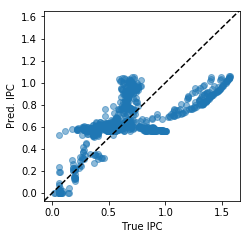

In [209]:
y_pred = new_model.predict(X_testVP)


import scipy as sp
# Plotting predicted vs true
print ("R:",  sp.stats.pearsonr(y_testVP, y_pred.flatten())[0])
print ("MAE:", np.abs(y_pred.flatten() - y_testVP).mean())
print ("RMSE:", np.sqrt(np.power(y_testVP- y_pred.flatten(), 2).mean()))


fig, ax = plt.subplots()

# Make the plot
ax.scatter(y_testVP, y_pred, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True IPC')
ax.set_ylabel('Pred. IPC')

fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');

In [210]:
history = new_model.fit(X, Y, epochs=500, batch_size=50,  verbose=1, validation_split=0.2)

Train on 1384 samples, validate on 347 samples
Epoch 1/500
1384/1384 [==============================] - 0s 23us/step - loss: 0.0588 - mean_squared_error: 0.0588 - mean_absolute_error: 0.1900 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.2009
Epoch 2/500
1384/1384 [==============================] - 0s 29us/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1935 - val_loss: 0.0613 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.2023
Epoch 3/500
1384/1384 [==============================] - 0s 27us/step - loss: 0.0575 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1940 - val_loss: 0.0611 - val_mean_squared_error: 0.0611 - val_mean_absolute_error: 0.2017
Epoch 4/500
1384/1384 [==============================] - 0s 33us/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1925 - val_loss: 0.0608 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.2008
Epoch 5/500
1384/1384 [==========

1384/1384 [==============================] - 0s 27us/step - loss: 0.0576 - mean_squared_error: 0.0576 - mean_absolute_error: 0.1937 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.2000
Epoch 37/500
1384/1384 [==============================] - 0s 27us/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1917 - val_loss: 0.0612 - val_mean_squared_error: 0.0612 - val_mean_absolute_error: 0.2015
Epoch 38/500
1384/1384 [==============================] - 0s 22us/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1936 - val_loss: 0.0610 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.2009
Epoch 39/500
1384/1384 [==============================] - 0s 22us/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1919 - val_loss: 0.0613 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.2017
Epoch 40/500
1384/1384 [==============================] - 0s 27us/step - loss: 0.0574 - m

1384/1384 [==============================] - 0s 26us/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1913 - val_loss: 0.0614 - val_mean_squared_error: 0.0614 - val_mean_absolute_error: 0.2015
Epoch 72/500
1384/1384 [==============================] - 0s 26us/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1926 - val_loss: 0.0610 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.2005
Epoch 73/500
1384/1384 [==============================] - 0s 30us/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1926 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1997
Epoch 74/500
1384/1384 [==============================] - 0s 31us/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1916 - val_loss: 0.0611 - val_mean_squared_error: 0.0611 - val_mean_absolute_error: 0.2009
Epoch 75/500
1384/1384 [==============================] - 0s 31us/step - loss: 0.0573 - m

1384/1384 [==============================] - 0s 26us/step - loss: 0.0571 - mean_squared_error: 0.0571 - mean_absolute_error: 0.1912 - val_loss: 0.0610 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1997
Epoch 107/500
1384/1384 [==============================] - 0s 27us/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1924 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1983
Epoch 108/500
1384/1384 [==============================] - 0s 28us/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1915 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1993
Epoch 109/500
1384/1384 [==============================] - 0s 31us/step - loss: 0.0571 - mean_squared_error: 0.0571 - mean_absolute_error: 0.1906 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1995
Epoch 110/500
1384/1384 [==============================] - 0s 32us/step - loss: 0.0574

1384/1384 [==============================] - 0s 27us/step - loss: 0.0572 - mean_squared_error: 0.0572 - mean_absolute_error: 0.1914 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1987
Epoch 142/500
1384/1384 [==============================] - 0s 27us/step - loss: 0.0570 - mean_squared_error: 0.0570 - mean_absolute_error: 0.1915 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.1983
Epoch 143/500
1384/1384 [==============================] - 0s 32us/step - loss: 0.0571 - mean_squared_error: 0.0571 - mean_absolute_error: 0.1906 - val_loss: 0.0608 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1990
Epoch 144/500
1384/1384 [==============================] - 0s 32us/step - loss: 0.0571 - mean_squared_error: 0.0571 - mean_absolute_error: 0.1919 - val_loss: 0.0603 - val_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.1971
Epoch 145/500
1384/1384 [==============================] - 0s 31us/step - loss: 0.0571

1384/1384 [==============================] - 0s 29us/step - loss: 0.0570 - mean_squared_error: 0.0570 - mean_absolute_error: 0.1905 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1979
Epoch 177/500
1384/1384 [==============================] - 0s 29us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1914 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1985
Epoch 178/500
1384/1384 [==============================] - 0s 30us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1903 - val_loss: 0.0608 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1987
Epoch 179/500
1384/1384 [==============================] - 0s 31us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1909 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1988
Epoch 180/500
1384/1384 [==============================] - 0s 29us/step - loss: 0.0569

1384/1384 [==============================] - 0s 31us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1902 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1992
Epoch 212/500
1384/1384 [==============================] - 0s 32us/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1909 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.1981
Epoch 213/500
1384/1384 [==============================] - 0s 28us/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1908 - val_loss: 0.0613 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1997
Epoch 214/500
1384/1384 [==============================] - 0s 33us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1902 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1991
Epoch 215/500
1384/1384 [==============================] - 0s 28us/step - loss: 0.0573

1384/1384 [==============================] - 0s 28us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1916 - val_loss: 0.0603 - val_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.1974
Epoch 247/500
1384/1384 [==============================] - 0s 27us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1897 - val_loss: 0.0604 - val_mean_squared_error: 0.0604 - val_mean_absolute_error: 0.1979
Epoch 248/500
1384/1384 [==============================] - 0s 28us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1907 - val_loss: 0.0602 - val_mean_squared_error: 0.0602 - val_mean_absolute_error: 0.1968
Epoch 249/500
1384/1384 [==============================] - 0s 31us/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1897 - val_loss: 0.0604 - val_mean_squared_error: 0.0604 - val_mean_absolute_error: 0.1980
Epoch 250/500
1384/1384 [==============================] - 0s 29us/step - loss: 0.0573

1384/1384 [==============================] - 0s 26us/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1895 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1984
Epoch 282/500
1384/1384 [==============================] - 0s 27us/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1902 - val_loss: 0.0608 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1983
Epoch 283/500
1384/1384 [==============================] - 0s 32us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1906 - val_loss: 0.0614 - val_mean_squared_error: 0.0614 - val_mean_absolute_error: 0.1999
Epoch 284/500
1384/1384 [==============================] - 0s 29us/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1904 - val_loss: 0.0603 - val_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.1972
Epoch 285/500
1384/1384 [==============================] - 0s 30us/step - loss: 0.0568

1384/1384 [==============================] - 0s 28us/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1894 - val_loss: 0.0602 - val_mean_squared_error: 0.0602 - val_mean_absolute_error: 0.1973
Epoch 317/500
1384/1384 [==============================] - 0s 28us/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1903 - val_loss: 0.0603 - val_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.1974
Epoch 318/500
1384/1384 [==============================] - 0s 32us/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1899 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.1982
Epoch 319/500
1384/1384 [==============================] - 0s 31us/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1900 - val_loss: 0.0610 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1991
Epoch 320/500
1384/1384 [==============================] - 0s 29us/step - loss: 0.0568

1384/1384 [==============================] - 0s 27us/step - loss: 0.0566 - mean_squared_error: 0.0566 - mean_absolute_error: 0.1886 - val_loss: 0.0601 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.1969
Epoch 352/500
1384/1384 [==============================] - 0s 26us/step - loss: 0.0565 - mean_squared_error: 0.0565 - mean_absolute_error: 0.1903 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1983
Epoch 353/500
1384/1384 [==============================] - 0s 28us/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1895 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1979
Epoch 354/500
1384/1384 [==============================] - 0s 33us/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1909 - val_loss: 0.0601 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.1970
Epoch 355/500
1384/1384 [==============================] - 0s 32us/step - loss: 0.0567

1384/1384 [==============================] - 0s 28us/step - loss: 0.0566 - mean_squared_error: 0.0566 - mean_absolute_error: 0.1890 - val_loss: 0.0604 - val_mean_squared_error: 0.0604 - val_mean_absolute_error: 0.1978
Epoch 387/500
1384/1384 [==============================] - 0s 27us/step - loss: 0.0565 - mean_squared_error: 0.0565 - mean_absolute_error: 0.1903 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1982
Epoch 388/500
1384/1384 [==============================] - 0s 32us/step - loss: 0.0566 - mean_squared_error: 0.0566 - mean_absolute_error: 0.1900 - val_loss: 0.0601 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.1974
Epoch 389/500
1384/1384 [==============================] - 0s 34us/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1899 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1987
Epoch 390/500
1384/1384 [==============================] - 0s 30us/step - loss: 0.0567

1384/1384 [==============================] - 0s 30us/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1897 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1980
Epoch 422/500
1384/1384 [==============================] - 0s 29us/step - loss: 0.0565 - mean_squared_error: 0.0565 - mean_absolute_error: 0.1904 - val_loss: 0.0599 - val_mean_squared_error: 0.0599 - val_mean_absolute_error: 0.1964
Epoch 423/500
1384/1384 [==============================] - 0s 29us/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1891 - val_loss: 0.0602 - val_mean_squared_error: 0.0602 - val_mean_absolute_error: 0.1975
Epoch 424/500
1384/1384 [==============================] - 0s 30us/step - loss: 0.0565 - mean_squared_error: 0.0565 - mean_absolute_error: 0.1903 - val_loss: 0.0600 - val_mean_squared_error: 0.0600 - val_mean_absolute_error: 0.1968
Epoch 425/500
1384/1384 [==============================] - 0s 33us/step - loss: 0.0565

1384/1384 [==============================] - 0s 28us/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1892 - val_loss: 0.0601 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.1970
Epoch 457/500
1384/1384 [==============================] - 0s 28us/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1912 - val_loss: 0.0596 - val_mean_squared_error: 0.0596 - val_mean_absolute_error: 0.1952
Epoch 458/500
1384/1384 [==============================] - 0s 32us/step - loss: 0.0565 - mean_squared_error: 0.0565 - mean_absolute_error: 0.1889 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1983
Epoch 459/500
1384/1384 [==============================] - 0s 33us/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1903 - val_loss: 0.0599 - val_mean_squared_error: 0.0599 - val_mean_absolute_error: 0.1962
Epoch 460/500
1384/1384 [==============================] - 0s 28us/step - loss: 0.0565

1384/1384 [==============================] - 0s 27us/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1892 - val_loss: 0.0604 - val_mean_squared_error: 0.0604 - val_mean_absolute_error: 0.1974
Epoch 492/500
1384/1384 [==============================] - 0s 26us/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1893 - val_loss: 0.0603 - val_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.1974
Epoch 493/500
1384/1384 [==============================] - 0s 24us/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1889 - val_loss: 0.0608 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1991
Epoch 494/500
1384/1384 [==============================] - 0s 30us/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1916 - val_loss: 0.0595 - val_mean_squared_error: 0.0595 - val_mean_absolute_error: 0.1945
Epoch 495/500
1384/1384 [==============================] - 0s 29us/step - loss: 0.0566

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


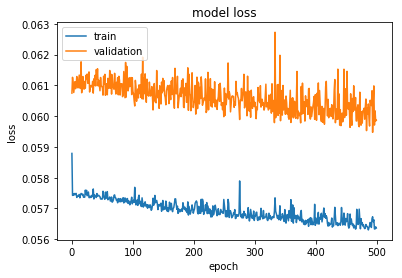

In [211]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()